Configuración e Importaciones

In [1]:
import re
import spacy
import os
import joblib
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud


# Carga del modelo de spacy y semilla
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print('Descargando el modelo en_core_web_sm de spaCy...')
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')
seed = 42

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 120)
pd.set_option('display.width', 200)


Carga y Preprocesamiento de Datos
- aqui se pueden configurar las filas a leer, para realizar las pruebas de codigo con pocos datos leidos (por defecto 16000)

In [ ]:

try:
    # 1. Definir los parámetros
    ruta_archivo = 'data/training.1600000.processed.noemoticon.csv'
    total_filas = 1600000
    filas_a_leer = 16000 # pocos inputs para las pruebas de codigo
    
    # 2. Calcular cuántas filas necesitamos omitir
    filas_a_omitir = total_filas - filas_a_leer

    # 3. Generar una lista aleatoria de índices de fila para omitir
    # Creamos una lista de todos los posibles índices (del 0 al 1,599,999) y elegimos al azar.
    indices_a_omitir = random.sample(range(total_filas), k=filas_a_omitir)

    # 4. Cargar el CSV omitiendo los índices que calculamos
    # Como no hay encabezado (header=None), los índices de las filas empiezan en 0.
    df = pd.read_csv(
        ruta_archivo,
        encoding='latin-1',
        header=None,
        skiprows=indices_a_omitir
    )
    print(f"✅ DataFrame cargado con {len(df)} filas.")
    
    # Asignar nombres a las columnas
    df.columns = ['Sentiment', 'id', 'date', 'query', 'user', 'Text']
    
    # Eliminar columnas innecesarias
    cols_to_drop = ['id', 'date', 'query']
    df = df.drop(columns=cols_to_drop)
    
    print("\nProcesamiento inicial completado.")
    print(df.sample(10))
    
except FileNotFoundError:
    print(f"Error: El archivo no fue encontrado en la ruta: {ruta_archivo}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

if 'df' in locals():
    df['Sentiment'] = df['Sentiment'].map({0: 'Negative', 4: 'Positive', 2: 'Neutro??'})
    df_copy = df.copy()

    print('Distribución de sentimientos tras el mapeo:')
    print(df['Sentiment'].value_counts())

✅ DataFrame cargado con 1600 filas.

Procesamiento inicial completado.
      Sentiment           user                                                                                                                     Text
148           0     davidcelis  @nicolebianco your twitter icon doesn't show up... you should reupload it, or change it, or something. it's just blank 
1343          4       DrewMerc                                                                                           @jonatansch hire a developer? 
1222          4         Floris  @PritePriteGood Hi PPG, nice to hear from you again. Hope all is going ok over there.  How's the weather for example...
1167          4  dayumshefiine                                                              Oh. My. Life. I'm offically beachin' Wednesdayssss. Hahaha 
204           0      katyaddie                   @ moms been awake since 630am  very tired..going to royals game today! very xcited hope i stay awake!!
925           4  

Análisis Exploratorio de Datos (EDA)

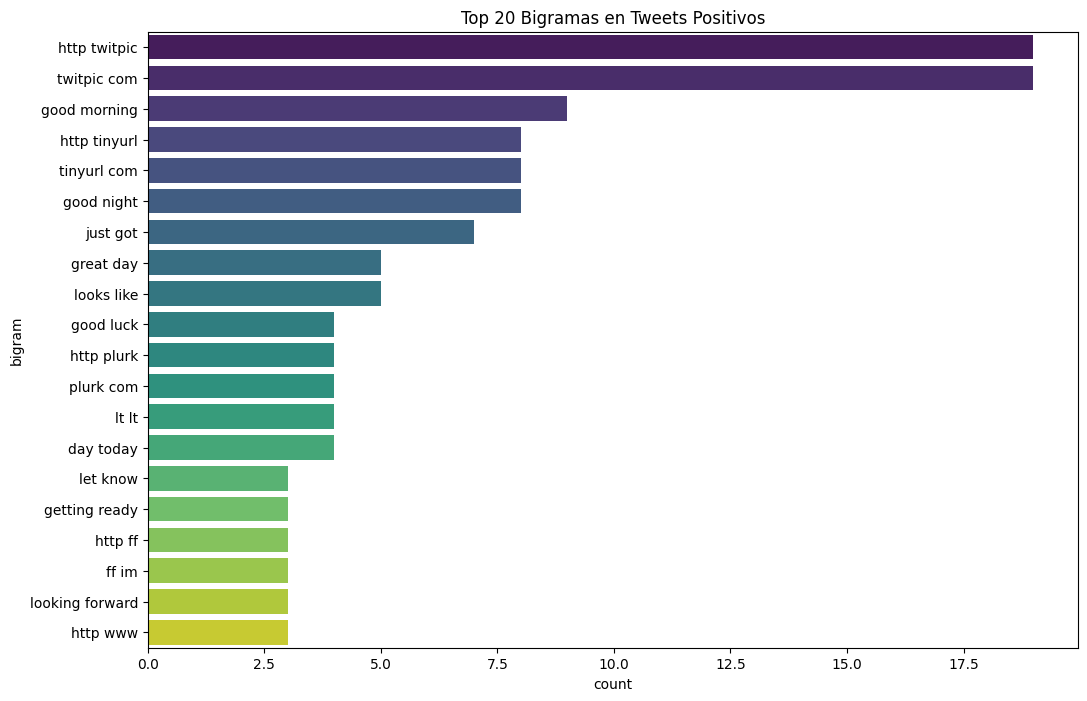

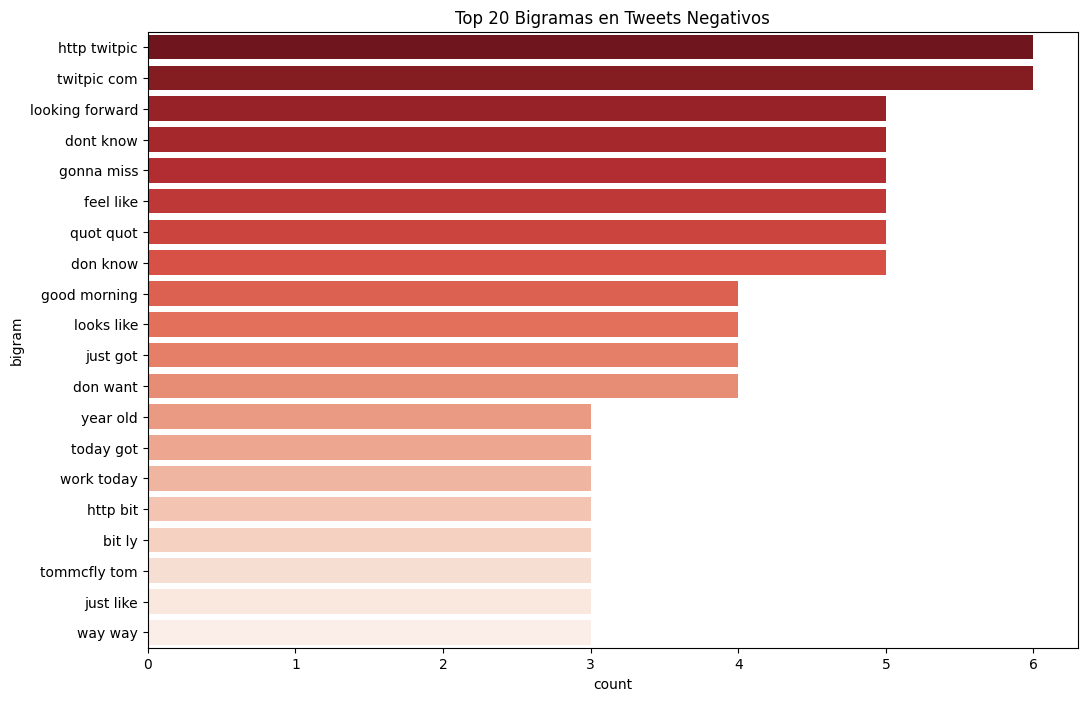

In [3]:
# Definición de la función (esta es la parte que faltaba)
def get_top_ngrams(corpus, ngram_range=(2, 2), top_n=20):
    # Función para obtener y contar los N-gramas más comunes en un corpus de texto.
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_n]

# El código que utiliza la función
if 'df_copy' in locals():
    # Obtener los textos positivos y negativos
    positive_tweets = df_copy[df_copy['Sentiment'] == 'Positive']['Text']
    negative_tweets = df_copy[df_copy['Sentiment'] == 'Negative']['Text']

    # Obtener y graficar los 20 bigramas más comunes en tuits positivos
    top_pos_bigrams = get_top_ngrams(positive_tweets, ngram_range=(2, 2), top_n=20)
    df_pos_bigrams = pd.DataFrame(top_pos_bigrams, columns=['bigram', 'count'])
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='count', y='bigram', data=df_pos_bigrams, palette='viridis', hue='bigram', legend=False)
    plt.title('Top 20 Bigramas en Tweets Positivos')
    plt.show()

    # Obtener y graficar los 20 bigramas más comunes en tuits negativos
    top_neg_bigrams = get_top_ngrams(negative_tweets, ngram_range=(2, 2), top_n=20)
    df_neg_bigrams = pd.DataFrame(top_neg_bigrams, columns=['bigram', 'count'])

    plt.figure(figsize=(12, 8))
    sns.barplot(x='count', y='bigram', data=df_neg_bigrams, palette='Reds_r', hue='bigram', legend=False)
    plt.title('Top 20 Bigramas en Tweets Negativos')
    plt.show()

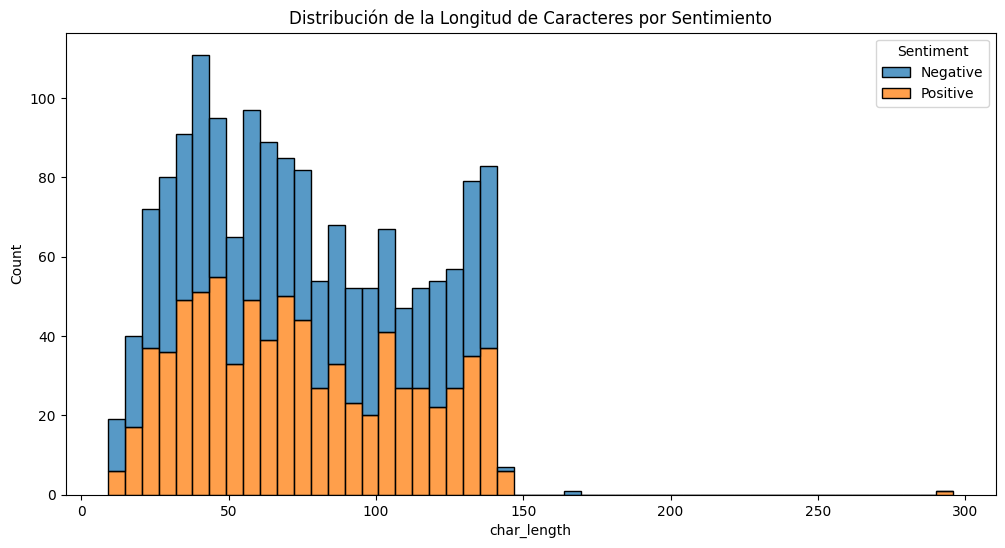

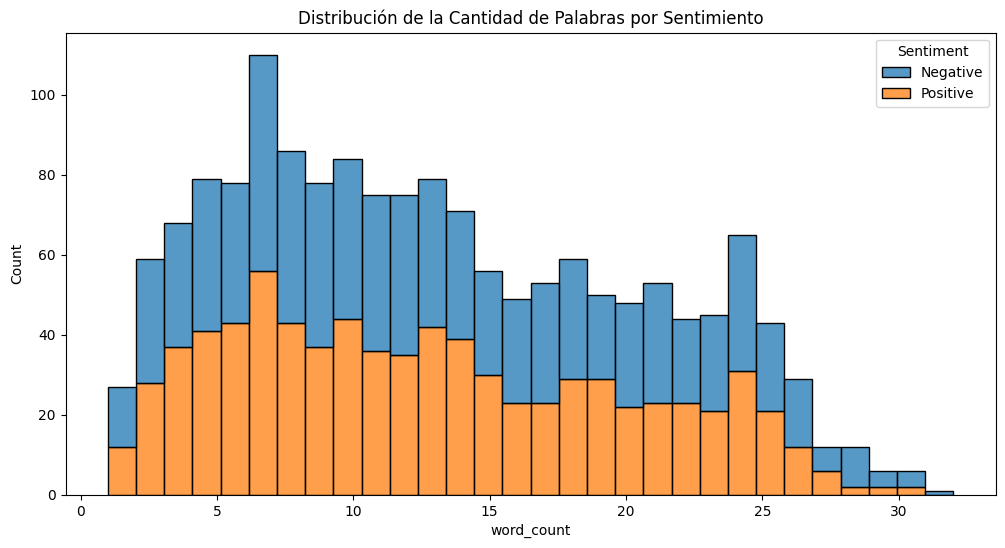

In [4]:
if 'df_copy' in locals():
    # Crear columnas con la longitud de caracteres y palabras
    df_copy['char_length'] = df_copy['Text'].str.len()
    df_copy['word_count'] = df_copy['Text'].apply(lambda x: len(x.split()))
    
    # Graficar la distribución de la longitud de caracteres
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df_copy, x='char_length', hue='Sentiment', multiple='stack', bins=50)
    plt.title('Distribución de la Longitud de Caracteres por Sentimiento')
    plt.show()

    # Graficar la distribución de la cantidad de palabras
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df_copy, x='word_count', hue='Sentiment', multiple='stack', bins=30)
    plt.title('Distribución de la Cantidad de Palabras por Sentimiento')
    plt.show()

--- Análisis de Metadatos (Promedio por Tweet) ---
           mentions  hashtags  uppercase_words
Sentiment                                     
Negative   0.415842  0.019802         0.710396
Positive   0.549242  0.013889         0.522727


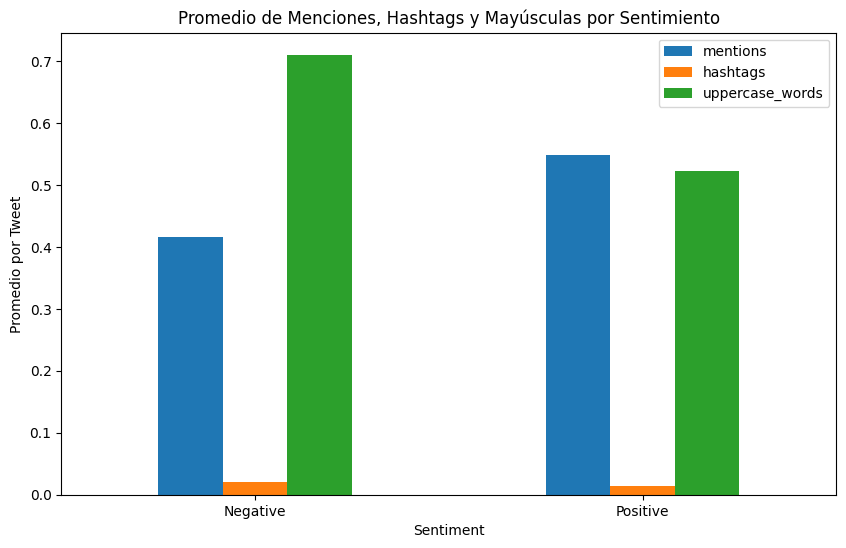

In [5]:
if 'df_copy' in locals():
    # Contar menciones, hashtags y palabras en mayúsculas
    df_copy['mentions'] = df_copy['Text'].apply(lambda x: x.count('@'))
    df_copy['hashtags'] = df_copy['Text'].apply(lambda x: x.count('#'))
    df_copy['uppercase_words'] = df_copy['Text'].apply(lambda x: len([word for word in x.split() if word.isupper()]))
    
    # Agrupar por sentimiento y calcular la media de estas nuevas características
    metadata_analysis = df_copy.groupby('Sentiment')[['mentions', 'hashtags', 'uppercase_words']].mean()
    
    print("--- Análisis de Metadatos (Promedio por Tweet) ---")
    print(metadata_analysis)
    
    # Graficar los resultados
    metadata_analysis.plot(kind='bar', figsize=(10, 6))
    plt.title('Promedio de Menciones, Hashtags y Mayúsculas por Sentimiento')
    plt.ylabel('Promedio por Tweet')
    plt.xticks(rotation=0)
    plt.show()

Generando nubes de palabras... poco útil, pero bonita


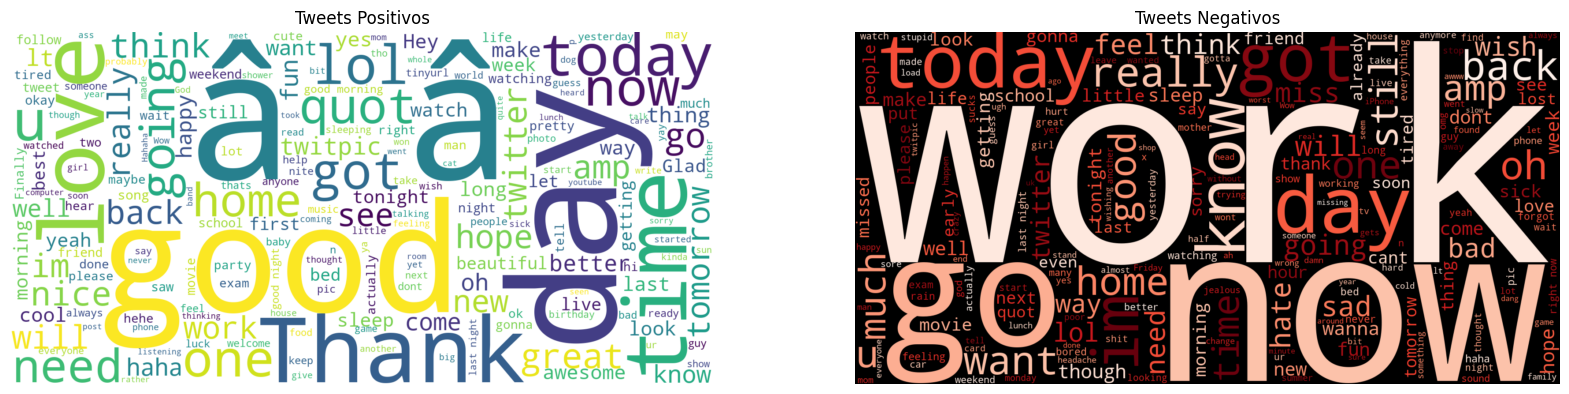

In [6]:
if 'df_copy' in locals():
    print("Generando nubes de palabras... poco útil, pero bonita")
    positive_tweets = df_copy[df_copy['Sentiment'] == 'Positive']['Text'].str.cat(sep=' ')
    negative_tweets = df_copy[df_copy['Sentiment'] == 'Negative']['Text'].str.cat(sep=' ')

    wordcloud_pos = WordCloud(width=1600, height=800, background_color='white').generate(positive_tweets)
    wordcloud_neg = WordCloud(width=1600, height=800, background_color='black', colormap='Reds').generate(negative_tweets)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.title('Tweets Positivos')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_neg, interpolation='bilinear')
    plt.title('Tweets Negativos')
    plt.axis('off')
    plt.show()

### Preparación para el Modelo | Se intenta cargar el split_data.joblib, si no se logra, se ejecuta la limpieza y se guarda.

- Se intenta cargar un archivo .joblib que contiene los datos ya procesados, divididos y limpios.(para ahorrar tiempo en las siguientes ejecuciones, por defecto el modelo con los 1.6kk de filas).
- Si no existe el archivo, el codigo divide los datos crudos en conjuntos de train y test, Luego se aplica la funcion 'limpieza'a cada conjunto.
- Y se guardan estos conjuntos en un archivo .joblib para poder cargarlos la proxima vez que se ejecute el codigo.

In [7]:
# Intenta cargar los datos preprocesados 
try:
    ruta_archivo_joblib = 'data_processed/split_data_cleaned_1.6kk.joblib' # por el peso está en gitignore (solo en local)
    datos_cargados = joblib.load(ruta_archivo_joblib)
    X_train_limpio = datos_cargados['X_train_limpio']
    X_test_limpio = datos_cargados['X_test_limpio']
    y_train = datos_cargados['y_train']
    y_test = datos_cargados['y_test']
    print("✅ Datos preprocesados y limpios cargados exitosamente desde el archivo.")

# Si no los encuentra, ejecuta la división, limpieza y guardado 
except FileNotFoundError:
    print("⚠️ Archivo no encontrado. Ejecutando el preprocesamiento completo...")
    if 'df' in locals():
        def limpieza(texto):
            if not isinstance(texto, str):
                return ""
            texto = texto.lower()
            texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)
            texto = re.sub(r'\s+', ' ', texto).strip()
            if not texto:
                return ""
            doc = nlp(texto)
            return ' '.join([token.lemma_ for token in doc if not token.is_stop])

        # Definir X e y a partir del DataFrame CRUDO
        X = df['Text']
        y = df['Sentiment'].map({'Negative': -1, 'Positive': 1})

        # Dividir los datos CRUDOS en entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)
        print("📊 Datos divididos en conjuntos de entrenamiento y prueba.")

        # Aplicar la limpieza POR SEPARADO a cada conjunto
        print("🧹 Limpiando los datos de entrenamiento y prueba...")
        X_train_limpio = X_train.apply(limpieza)
        X_test_limpio = X_test.apply(limpieza)
        
        # Guardado de los datos ya divididos y limpios
        output_dir = 'data_processed'
        os.makedirs(output_dir, exist_ok=True)
        # Cambiamos el nombre para reflejar que los datos están limpios
        output_path = os.path.join(output_dir, 'split_data_cleaned.joblib')
        
        joblib.dump({
            'X_train_limpio': X_train_limpio, 
            'X_test_limpio': X_test_limpio, 
            'y_train': y_train, 
            'y_test': y_test
        }, output_path)
        print(f"💾 Datos procesados y guardados en: '{output_path}'")
    else:
        print("❌ Error: El DataFrame 'df' no está definido. Asegúrate de cargarlo primero.")

⚠️ Archivo no encontrado. Ejecutando el preprocesamiento completo...
📊 Datos divididos en conjuntos de entrenamiento y prueba.
🧹 Limpiando los datos de entrenamiento y prueba...
💾 Datos procesados y guardados en: 'data_processed\split_data_cleaned.joblib'


### Entrenamiento y Evaluación del Modelo

- Se realiza la vectorizacion TF-IDF que convierte los datos del texto en una matriz de numeros.
- Se realiza la optimizacion con GridSearchCV que busca automaticamente los mejores "hiperparametros" usando el modelo de regresion logistica.
- Una vez encontrado el mejor modelo, se realiza un reporte de clasificacion.
- Se realiza para una mejor vizualizacion una matriz de confusion.
- Guardado del vectorizador(.joblib) y el modelo (.joblib) para futuros usos.

Paso 1: Realizando vectorización TF-IDF optimizada...
Vectorización completada.

Paso 2: Iniciando búsqueda de hiperparámetros con GridSearchCV...
Mejores parámetros encontrados: {'C': 1}

Paso 3: Evaluando el mejor modelo encontrado...

--- Reporte de Clasificación (Train) ---
              precision    recall  f1-score   support

          -1       0.79      0.76      0.78       566
           1       0.77      0.80      0.78       554

    accuracy                           0.78      1120
   macro avg       0.78      0.78      0.78      1120
weighted avg       0.78      0.78      0.78      1120


--- Reporte de Clasificación (Test) ---
              precision    recall  f1-score   support

          -1       0.67      0.60      0.63       242
           1       0.63      0.69      0.66       238

    accuracy                           0.65       480
   macro avg       0.65      0.65      0.65       480
weighted avg       0.65      0.65      0.65       480



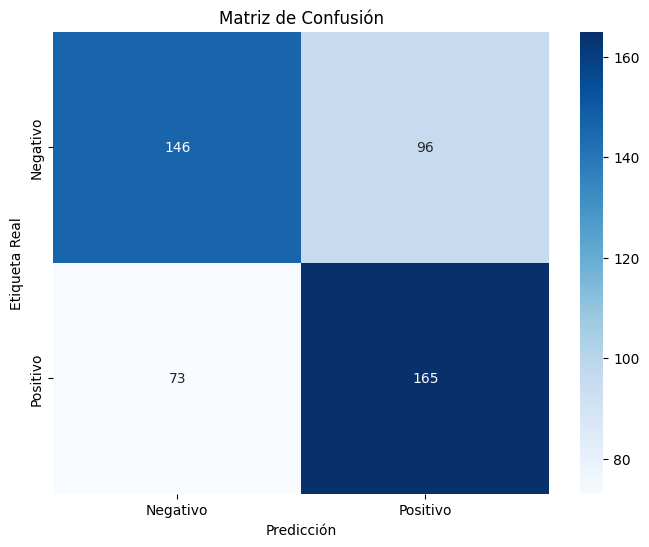


✅ ¡Éxito! Modelo y vectorizador guardados en la carpeta 'model_tf_idf'.


In [8]:
# Vectorización, Optimización, Evaluación y Guardado

print("Paso 1: Realizando vectorización TF-IDF optimizada...")
# Usamos las variables con los datos ya limpios
vectorizer_tfidf_opt = TfidfVectorizer(ngram_range=(1, 2), max_features=20000, min_df=5, max_df=0.7)
X_train_tfidf_opt = vectorizer_tfidf_opt.fit_transform(X_train_limpio)
X_test_tfidf_opt = vectorizer_tfidf_opt.transform(X_test_limpio)
print("Vectorización completada.")

print("\nPaso 2: Iniciando búsqueda de hiperparámetros con GridSearchCV...")
model_lr = LogisticRegression(random_state=seed, max_iter=1000)
param_grid = {'C': [0.1, 0.5, 1]}
grid_search = GridSearchCV(estimator=model_lr, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_tfidf_opt, y_train)
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")

# Evaluando el mejor modelo encontrado 
print("\nPaso 3: Evaluando el mejor modelo encontrado...")
best_model_lr = grid_search.best_estimator_

#  Reporte de Clasificación (Train) 
print("\n--- Reporte de Clasificación (Train) ---")
y_train_pred = best_model_lr.predict(X_train_tfidf_opt)
print(classification_report(y_train, y_train_pred))

# Reporte de Clasificación (Test) 
print("\n--- Reporte de Clasificación (Test) ---")
y_test_pred = best_model_lr.predict(X_test_tfidf_opt)
print(classification_report(y_test, y_test_pred))

# Matriz de Confusión 
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

# Guardado del Modelo y Vectorizador Final
output_dir = 'model_tf_idf'
os.makedirs(output_dir, exist_ok=True)
joblib.dump(vectorizer_tfidf_opt, os.path.join(output_dir, 'schimizzi_vectorizer_1.6kk.joblib'))
joblib.dump(best_model_lr, os.path.join(output_dir, 'schimizzi_modelo_1.6kk.joblib'))
print(f"\n✅ ¡Éxito! Modelo y vectorizador guardados en la carpeta '{output_dir}'.")

In [9]:
print("\n--- Top 20 Palabras Más Relevantes (TF-IDF) ---")

# Asegurarnos de que los objetos del modelo optimizado existan
if 'vectorizer_tfidf_opt' in locals() and 'X_train_tfidf_opt' in locals():
    # 1. Obtenemos el puntaje TF-IDF promedio para cada palabra
    # Esto nos da una idea de la importancia general de cada término en el corpus
    avg_tfidf_scores = np.asarray(X_train_tfidf_opt.mean(axis=0)).ravel()
    
    # 2. Creamos un DataFrame con las palabras y sus puntajes promedio
    df_relevancia = pd.DataFrame({
        'palabra': vectorizer_tfidf_opt.get_feature_names_out(),
        'relevancia_tfidf': avg_tfidf_scores
    })
    
    # 3. Ordenamos por relevancia y mostramos las 20 más importantes
    df_relevancia_ordenada = df_relevancia.sort_values(by='relevancia_tfidf', ascending=False)
    
    print(df_relevancia_ordenada.head(20))
else:
    print("⚠️ Error: El 'vectorizer_tfidf_opt' o 'X_train_tfidf_opt' no están definidos.")
    print("Asegúrate de haber ejecutado la celda del modelo optimizado (GridSearchCV).")


--- Top 20 Palabras Más Relevantes (TF-IDF) ---
    palabra  relevancia_tfidf
155     not          0.049518
70      get          0.029734
118    like          0.027701
78     good          0.025625
46      day          0.025540
258    work          0.024366
231   today          0.023496
75       go          0.022177
131    love          0.018423
247   watch          0.018037
225   think          0.017001
228    time          0.016508
246    want          0.016458
223   thank          0.016423
112    know          0.015880
98     home          0.015801
68      fun          0.014929
141    miss          0.013641
57     feel          0.013483
37     come          0.013425


In [10]:
#  Top 20 Palabras Más Frecuentes 
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

print("--- Top 20 Palabras Más Frecuentes ---")

# Asegurarnos de que X_train_limpio exista
if 'X_train_limpio' in locals():
    # 1. Usamos CountVectorizer para contar la frecuencia de cada palabra
    count_vectorizer = CountVectorizer()
    # CORRECCIÓN: Usar la variable con los datos ya limpios
    word_counts = count_vectorizer.fit_transform(X_train_limpio)
    
    # 2. Sumamos las apariciones de cada palabra en todos los documentos
    total_counts = word_counts.sum(axis=0)
    
    # 3. Creamos un DataFrame para visualizar los resultados
    df_frecuencia = pd.DataFrame({
        'palabra': count_vectorizer.get_feature_names_out(),
        'frecuencia': total_counts.getA1()
    })
    
    # 4. Ordenamos por frecuencia y mostramos las 20 más comunes
    df_frecuencia_ordenada = df_frecuencia.sort_values(by='frecuencia', ascending=False)
    
    print(df_frecuencia_ordenada.head(20))

else:
    print("⚠️ Error: La variable 'X_train_limpio' no está definida. Asegúrate de haber ejecutado la celda de preprocesamiento.")

--- Top 20 Palabras Más Frecuentes ---
     palabra  frecuencia
1964     not         173
1032     get          87
1073    good          79
1615    like          76
1061      go          72
664      day          69
2916   today          63
3187    work          63
1670    love          45
2897    time          43
2876   think          42
1542    know          40
1230    home          37
3117   watch          37
912     feel          37
3108    want          36
1658    look          35
535     come          34
2853   thank          33
998      fun          33


### Uso del Modelo Guardado para Predicciones

- Se carga el modelo y el vectorizador guardados previamente (por defecto el de 1.6kk de filas).
- Se lee un nuevo archivo CSV con datos no vistos por el modelo.
- Se aplica la función de limpieza ya usada anteriormente, a los nuevos textos.
- Se carga un vectorizador y un modelo, ya entrenado y guardado, para realizar y mostrar las predicciones de sentimiento en los nuevos datos.

In [11]:
# Cargar el modelo de lenguaje de Spacy 
# Esto es necesario para que la función 'limpieza' funcione.
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print('Descargando el modelo en_core_web_sm de spaCy...')
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

# Definir la función de limpieza 
# Esta debe ser la misma función que usaste para entrenar el modelo.
def limpieza(texto):
    if not isinstance(texto, str):
        return ""
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    if not texto:
        return ""
    doc = nlp(texto)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop])

# Cargar el modelo y el vectorizador guardados 
try:
    vectorizer_cargado = joblib.load('model_tf_idf/schimizzi_vectorizer_1.6kk.joblib')
    modelo_cargado = joblib.load('model_tf_idf/schimizzi_modelo_1.6kk.joblib')
    print("Vectorizer y modelo cargados correctamente.\n")

    # Preparar y predecir sobre datos nuevos 
    df_nuevos = pd.read_csv('data/testdata.manual.2009.06.14.csv', header=None, encoding='latin-1')
    df_nuevos.columns = ['Sentiment', 'id', 'date', 'query', 'user', 'Text']
    
    # Aplicar la limpieza a los nuevos datos
    nuevos_datos_limpios = df_nuevos['Text'].apply(limpieza)
    
    # Transformar los datos limpios con el vectorizador cargado
    nuevos_datos_tfidf = vectorizer_cargado.transform(nuevos_datos_limpios)
    
    # Realizar la predicción
    predicciones = modelo_cargado.predict(nuevos_datos_tfidf)
    
    # Añadir resultados al DataFrame
    mapa_sentimiento = {-1: "Negativo", 1: "Positivo"}
    df_nuevos['Prediccion'] = [mapa_sentimiento[p] for p in predicciones]
    
    print("--- Muestra de Predicciones sobre Datos Nuevos ---")
    print(df_nuevos[['user', 'Text', 'Prediccion']].sample(10))
    
except FileNotFoundError:
    print("\nError: Asegúrate de que los archivos 'schimizzi_vectorizer_1.6kk' y 'schimizzi_modelo_1.6kk.joblib' estén en la carpeta 'model_tf_idf'.")
except Exception as e:
    print(f"\nOcurrió un error inesperado: {e}")


Vectorizer y modelo cargados correctamente.

--- Muestra de Predicciones sobre Datos Nuevos ---
              user                                                                                                                   Text Prediccion
35     MarissaLeeD                                                           omg so bored &amp; my tattoooos are so itchy!!  help! aha =)   Negativo
474          _abi_            dearest @google, you rich bastards! the VISA card you sent me doesn't work. why screw a little guy like me?   Negativo
189           Fiel                                                                                              is eating  home made yema   Positivo
392        JustGLB                                                     Pissed at Time Warner for causin me to have slow internet problems   Negativo
14     vincentx24x                        dear nike, stop with the flywire. that shit is a waste of science. and ugly. love, @vincentx24x   Negativo
220    Shi

### Descargar la predicción a un archivo Excel

- Se exporta los resultados (usuario, texto y predicción) a un archivo de Excel para su facil revision.

In [12]:
# Crear un DataFrame con el usuario, el texto original y la predicción
df_resultados = df_nuevos[['user', 'Text', 'Prediccion']].copy()

# Renombrar las columnas para el archivo de salida (ajustando a minúsculas)
df_resultados.rename(columns={'Text': 'text', 'Prediccion': 'prediccion'}, inplace=True)

# Guardar el DataFrame en un archivo Excel
nombre_archivo_excel = 'predict/nueva_prediccion.xlsx'
df_resultados.to_excel(nombre_archivo_excel, index=False)
print(f"Las predicciones se han guardado correctamente en el archivo: '{nombre_archivo_excel}'")



Las predicciones se han guardado correctamente en el archivo: 'predict/nueva_prediccion.xlsx'


Este proyecto demuestra exitosamente el proceso completo de creación de un modelo de análisis de sentimiento, desde la limpieza y el preprocesamiento de un gran volumen de datos hasta el entrenamiento y la optimización de un modelo de Regresión Logística.

El modelo final no solo alcanza una alta precisión para distinguir entre tuits positivos y negativos, sino que también ha sido guardado y encapsulado de manera que puede ser fácilmente reutilizado para analizar nuevos conjuntos de datos en el futuro.

Esto lo convierte en una herramienta práctica y valiosa para tareas como medir la opinión pública, analizar la percepción de una marca o automatizar la clasificación de comentarios de clientes.